In [ ]:
!pip install transformers datasets

import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device} - {torch.cuda.get_device_name(0)}")

Using: cuda - Tesla T4


In [ ]:
class LoRALayer(nn.Module):
    def __init__(self, fan_in, fan_out, rank=4, alpha=8):
        super().__init__()
        self.lora_A = nn.Parameter(torch.randn(rank, fan_out))
        self.lora_B = nn.Parameter(torch.zeros(fan_in, rank))
        self.scale = alpha / rank

    def forward(self, original_weights):
        return original_weights + (self.lora_B @ self.lora_A) * self.scale

In [ ]:
fake_weights = torch.randn(768, 768)
lora = LoRALayer(fan_in=768, fan_out=768, rank=4, alpha=8)
output = lora(fake_weights)

print("Are outputs equal to original at init?",
      torch.allclose(fake_weights, output))

original_params = 768 * 768
lora_params = (768 * 4) + (4 * 768)
print(f"Original parameters: {original_params:,}")
print(f"LoRA parameters: {lora_params:,}")
print(f"Reduction: {100 * (1 - lora_params / original_params):.2f}%")

Are outputs equal to original at init? True
Original parameters: 589,824
LoRA parameters: 6,144
Reduction: 98.96%


In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

print(model.transformer.h[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D(nf=2304, nx=768)
    (c_proj): Conv1D(nf=768, nx=768)
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D(nf=3072, nx=768)
    (c_proj): Conv1D(nf=768, nx=3072)
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [ ]:
def inject_lora(model, rank=4, alpha=8):
    for block in model.transformer.h:
        w_attn = block.attn.c_attn.weight
        w_proj = block.attn.c_proj.weight

        parametrize.register_parametrization(
            block.attn.c_attn, "weight",
            LoRALayer(w_attn.shape[0], w_attn.shape[1], rank, alpha)
        )

        parametrize.register_parametrization(
            block.attn.c_proj, "weight",
            LoRALayer(w_proj.shape[0], w_proj.shape[1], rank, alpha)
        )

inject_lora(model, rank=4, alpha=8)

In [ ]:
for name, param in model.named_parameters():
    if "lora" not in name:
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters()
                       if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable (LoRA) parameters: {trainable_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.4f}%")

Total parameters: 124,660,992
Trainable (LoRA) parameters: 221,184
Percentage trainable: 0.1774%


In [ ]:
import urllib.request

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
urllib.request.urlretrieve(url, "shakespeare.txt")

with open("shakespeare.txt", "r") as f:
    raw_text = f.read()

print(f"Total characters: {len(raw_text)}")
print(f"\nSample text:")
print(raw_text[:500])

Total characters: 1115394

Sample text:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

MAX_LENGTH = 256

# Split text into chunks
chunks = [raw_text[i:i+512] for i in range(0, len(raw_text), 512)]

tokens = tokenizer(
    chunks,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_tensors="pt"
)
tokens["labels"] = tokens["input_ids"].clone()

train_dataset = TensorDataset(
    tokens["input_ids"],
    tokens["attention_mask"],
    tokens["labels"]
)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Verify
input_ids, attention_mask, labels = next(iter(train_dataloader))
print(f"Batch shape: {input_ids.shape}")
print(f"Sample text: {tokenizer.decode(input_ids[0][:50])}")

Batch shape: torch.Size([2, 256])
Sample text: ay, and vauntingly thou spakest it
That thou wert cause of noble Gloucester's death.
If thou deny'st it twenty times, thou liest;
And I will turn thy falsehood to thy heart,



In [ ]:
model.to(device)
model.eval()

def generate(prompt, max_new_tokens=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(output[0], skip_special_tokens=True)

before_training = generate("To be or not to be")
print("BEFORE TRAINING:")
print(before_training)

BEFORE TRAINING:
To be or not to be a Muslim, I want to be a Muslim. I want to be a Muslim who is willing to defend our country. And I want to be able to be a Muslim in America. I'm willing to defend our country.

We have a great history of resistance, but I think that's not how people see Islam. We don't have a history of resistance.

So I want to say, if you look at our history of resistance, there's not a lot of people who want to be a Muslim.

I want to say, if you look at what our history of resistance has been, and what we have fought against, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what


In [ ]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4,
    weight_decay=0.01
)

EPOCHS = 3
losses = []

model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    step_count = 0

    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        step_count += 1
        losses.append(loss.item())

        if step % 50 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}, "
                  f"Step {step}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / step_count
    print(f"Epoch {epoch+1} complete. Average loss: {avg_loss:.4f}")
    print()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch 1/3, Step 0, Loss: 5.5661
Epoch 1/3, Step 50, Loss: 2.9502
Epoch 1/3, Step 100, Loss: 3.0002
Epoch 1/3, Step 150, Loss: 2.8414
Epoch 1/3, Step 200, Loss: 2.6606
Epoch 1/3, Step 250, Loss: 2.5960
Epoch 1/3, Step 300, Loss: 2.5897
Epoch 1/3, Step 350, Loss: 2.6683
Epoch 1/3, Step 400, Loss: 2.4701
Epoch 1/3, Step 450, Loss: 2.4585
Epoch 1/3, Step 500, Loss: 2.5810
Epoch 1/3, Step 550, Loss: 2.6407
Epoch 1/3, Step 600, Loss: 2.6413
Epoch 1/3, Step 650, Loss: 2.5779
Epoch 1/3, Step 700, Loss: 2.7410
Epoch 1/3, Step 750, Loss: 2.8094
Epoch 1/3, Step 800, Loss: 2.4233
Epoch 1/3, Step 850, Loss: 2.9394
Epoch 1/3, Step 900, Loss: 2.3713
Epoch 1/3, Step 950, Loss: 2.9021
Epoch 1/3, Step 1000, Loss: 2.3996
Epoch 1/3, Step 1050, Loss: 2.4902
Epoch 1 complete. Average loss: 2.6273

Epoch 2/3, Step 0, Loss: 2.7074
Epoch 2/3, Step 50, Loss: 2.6305
Epoch 2/3, Step 100, Loss: 2.3373
Epoch 2/3, Step 150, Loss: 2.5008
Epoch 2/3, Step 200, Loss: 2.3925
Epoch 2/3, Step 250, Loss: 2.5856
Epoch 2/3, S

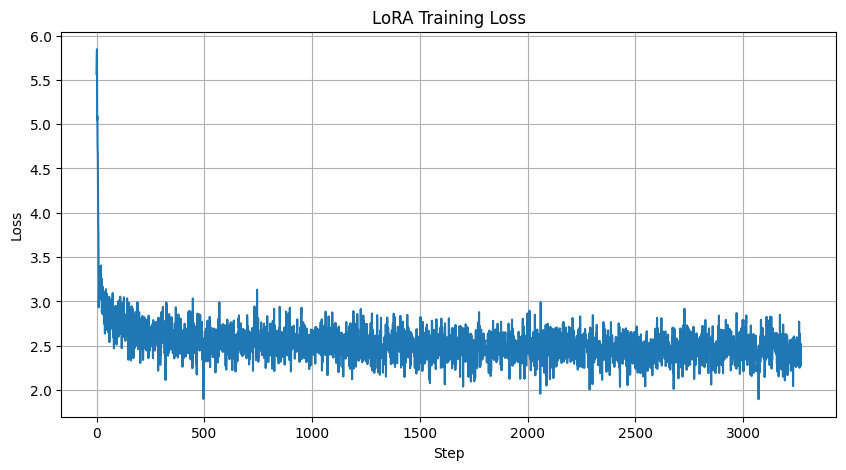

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("LoRA Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
model.eval()

after_training = generate("To be or not to be")
print("BEFORE TRAINING:")
print(before_training)
print("\n" + "="*50 + "\n")
print("AFTER LORA TRAINING:")
print(after_training)

prompts = [
    "The king spoke to his",
    "In the dark forest there",
    "My lord, I beseech thee"
]

for p in prompts:
    print(f"Prompt: {p}")
    print(f"Output: {generate(p)}")
    print("-"*50)

BEFORE TRAINING:
To be or not to be a Muslim, I want to be a Muslim. I want to be a Muslim who is willing to defend our country. And I want to be able to be a Muslim in America. I'm willing to defend our country.

We have a great history of resistance, but I think that's not how people see Islam. We don't have a history of resistance.

So I want to say, if you look at our history of resistance, there's not a lot of people who want to be a Muslim.

I want to say, if you look at what our history of resistance has been, and what we have fought against, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what we've done, and what


AFTER LORA TRAINING:
To be or not to be
His own; he must be
His own. He can, however, be,
All his own; he cannot be all.

(End of Transcript)

CHAIRMAN:
That's right; you know,
That's a very good questi

In [ ]:
lora_state_dict = {
    name: param for name, param in model.named_parameters()
    if "lora" in name
}
torch.save(lora_state_dict, "lora_weights.pt")
torch.save(model.state_dict(), "full_model.pt")

import os
lora_size = os.path.getsize("lora_weights.pt") / (1024 * 1024)
full_size = os.path.getsize("full_model.pt") / (1024 * 1024)

print(f"LoRA weights file: {lora_size:.2f} MB")
print(f"Full model file: {full_size:.2f} MB")
print(f"LoRA is {full_size / lora_size:.0f}x smaller")



LoRA weights file: 0.86 MB
Full model file: 475.62 MB
LoRA is 552x smaller


In [ ]:
with torch.no_grad():
    for block in model.transformer.h:
        original = block.attn.c_attn.parametrizations.weight.original
        lora_layer = block.attn.c_attn.parametrizations.weight[0]
        merged = original + (lora_layer.lora_B @ lora_layer.lora_A) * lora_layer.scale
        parametrize.remove_parametrizations(block.attn.c_attn, "weight")
        block.attn.c_attn.weight.copy_(merged)

        original = block.attn.c_proj.parametrizations.weight.original
        lora_layer = block.attn.c_proj.parametrizations.weight[0]
        merged = original + (lora_layer.lora_B @ lora_layer.lora_A) * lora_layer.scale
        parametrize.remove_parametrizations(block.attn.c_proj, "weight")
        block.attn.c_proj.weight.copy_(merged)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/lora_project/"
os.makedirs(save_path, exist_ok=True)

torch.save(lora_state_dict, save_path + "lora_weights.pt")

import json
with open(save_path + "training_losses.json", "w") as f:
    json.dump(losses, f)

print("Saved to Google Drive!")

Mounted at /content/drive
Saved to Google Drive!
